# Оценка важности признаков

Оценка производится только для двух моделей: CatBoostClassifier и RandomForestClassifier с помощью библиотеки SHAP. В данные добавляется несколько столбцов со случайными величинами для оценки того, насколько тот или иной признак важнее, чем случайный.

In [1]:
from itertools import takewhile

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import shap
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [5]:
from utils import RANDOM_SEED, TARGET_FEATURE, FIG_SIZES, DFS_NAME, SCORER, FEATURE_NAMES, RANDOM_GENERATOR
from utils import read, write, split, score

In [6]:
SAMPLE_SIZE = 100

In [7]:
dfs = read(DFS_NAME)
f, t = split(dfs[1].dropna(subset=TARGET_FEATURE))

n = [2, 2]
for i in range(n[0]):
    f[f"random_feature_{i}"] = RANDOM_GENERATOR.rand(f.shape[0])
for i in range(n[1]):
    f[f"random_feature_{i + n[0]}"] = RANDOM_GENERATOR.rand(f.shape[0]) - 0.5

In [8]:
def fit(model):
    model.fit(f, t)
    return model

def te(model, max_features=20):
    sample = f.sample(SAMPLE_SIZE, random_state=RANDOM_SEED)
    shap_test = shap.TreeExplainer(model).shap_values(sample)
    shap.summary_plot(shap_test, sample, max_display=max_features, plot_size=(15, 0.3 * min(max_features, len(sample.columns))))
    return shap_test

def get_features(shap_test_res):
    if isinstance(shap_test_res, list):
        temp = abs(shap_test_res[1]).mean(axis=0)
    else:
        temp = abs(shap_test_res).mean(axis=0)
    features = sorted(zip(temp, f.columns), key=lambda x: x[0], reverse=True)
    return [x[1] for x in takewhile(lambda x: 'random_feature' not in x[1], features)]

# Random Forest

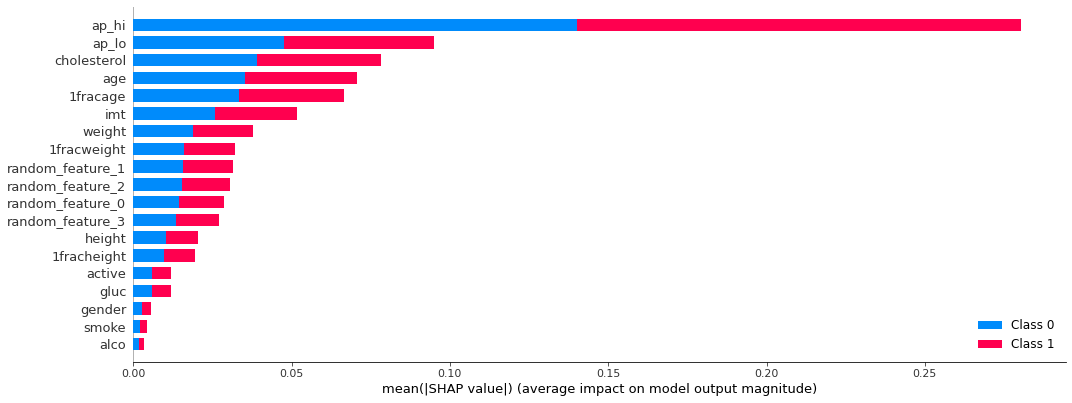

Wall time: 30.2 s


In [9]:
%%time
model = fit(RandomForestClassifier(random_state=RANDOM_SEED))
st = te(model)
features_rf = get_features(st)

# Catboost

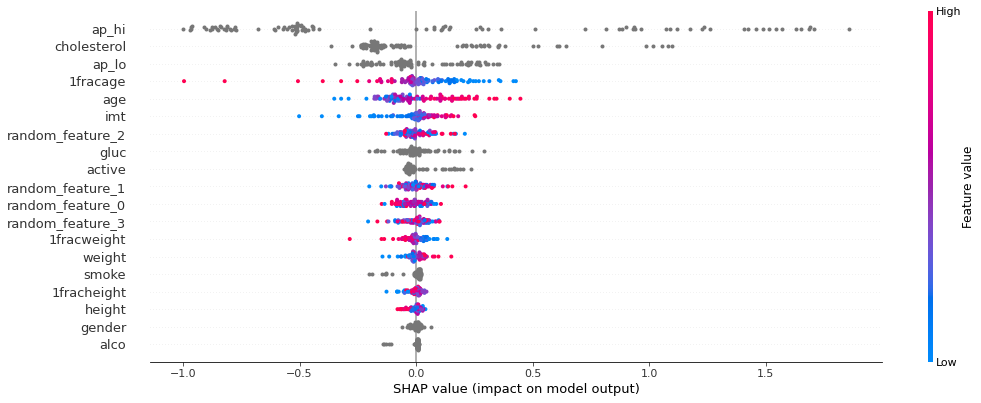

Wall time: 34.7 s


In [10]:
%%time
param = {'cat_features': list(f.select_dtypes(include='category').columns),
         'random_state': RANDOM_SEED,
         'verbose': 0}
model = fit(CatBoostClassifier(**param))
st = te(model)
features_cb = get_features(st)

In [11]:
features = list(set(features_rf + features_cb))
print(*sorted(features), sep='\n')

1fracage
1fracweight
age
ap_hi
ap_lo
cholesterol
imt
weight


In [12]:
write(FEATURE_NAMES, features)